In [1]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, concatenate_datasets
import evaluate
import os
import json
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 


In [ ]:
# OPTIONAL - FOR UPLOADING TO HUGGINGFACE
# from huggingface_hub import notebook_login
# # # copy and paste this code in the terminal: huggingface-cli login 
# # then paste this read token (you will have to construct it)


# notebook_login()

## Import the dataset

In [144]:

df_path = "../../../eHRAF_Scraper-Analysis-and-Prep/Data/"
dataFolder = r"(subjects-(contracts_OR_disabilities_OR_disasters_OR_friendships_OR_gift_giving_OR_infant_feeding_OR_lineages_OR_local_officials_OR_luck_and_chance_OR_magicians_and_diviners_OR_mortuary_specialists_OR_nuclear_family_OR_priesthood_OR_prophet/"
# dataFolder = r'subjects-(sickness)_FILTERS-culture_level_samples(PSF)'


# Get model and centralized path if relevent
model_name = "HRAF_MultiLabel_SubClasses_Kfolds"
path = f"" #Path to centralized file locations (leave blank if centralized location is here)



# load df (only load one of these commented out lines)
# df = pd.read_excel(f"{df_path}{dataFolder}/_Altogether_Dataset_RACoded.xlsx", header=[0,1], index_col=0) # Fall 2023 sickness + non-sickness
df = pd.read_excel(f"{df_path}{dataFolder}/_Altogether_Dataset_RACoded_Combined.xlsx", header=[0,1], index_col=0) # Spring 2023 - Spring 2024  sickness + nonsickness dataset
df.head(3)

CULTURE                               \
  Passage Number Region   SubRegion   Culture   
0           1392   Asia  South Asia  Andamans   
1           1393   Asia  South Asia  Andamans   
2           1395   Asia  South Asia  Andamans   

                                                                     \
                                            DocTitle        Section   
0  Hygiene and medical practices among the Onge (...  1. Habitation   
1  Hygiene and medical practices among the Onge (...        3. Food   
2  Hygiene and medical practices among the Onge (...        3. Food   

                               \
            Author Page  Year   
0  Cipriani, Lidio  484  1961   
1  Cipriani, Lidio  487  1961   
2  Cipriani, Lidio  490  1961   

                                                      ... ACTION  \
                                                 OCM  ...  Other   
0  ['171', '301', '727', '751', '765', '775', '777']  ...      1   
1  ['136', '231', '271', '312', '415', '516', '751']  ...      0   
2  ['114', '137', '164', '262', '273', '751', '825']  ...      0   

                                                      \
                                         Description   
0  Several customs are believed to connect with t...   
1                             No action is mentioned   
2  Certain foods, such as Pteropus (giant bat) an...   

                                                      \
                                         Local_terms   
0   ibidanghe: made from decorated human jawbone ...   
1                                                  0   
2  Pteropus: a giant bat  eaten by the Andaman Is...   

                                               OTHER      CODER           \
                                      Other_Comments Run_Number Finished   
0  General note of this spreadsheet - many of the...          1     True   
1                                                NaN          1     True   
2                                                NaN          1     True   

                   OTHER   CODER  \
  Coder Other_Comments.1 Dataset   
0    YM              NaN       1   
1    YM              NaN       1   
2    YM              NaN       1   

                                                      
                                                Info  
0  Dataset 1: ['750', '751', '752', '753']   Coun...  
1  Dataset 2: ['784', '731', '732', '777', '791',...  
2  Run 1: Spring 2023 Coding of Sickness dataset ...  

[3 rows x 43 columns]

## Preprocess

### Remove Duplicates

There were multiple iterations of Research Assistants labeling the data. <br>
We will just use run number 1 and 3 with preference to 3 when there are duplicates (as it is the most recent and robust)



In [145]:
# Show run number and dataset
df["CODER"][["Run_Number", "Dataset"]].value_counts(sort=False, dropna=False)

Run_Number  Dataset
1           1          1926
2           1            51
3           1          4844
            2          4184
Name: count, dtype: int64

In [146]:
# useRuns = [1,3] #Only include these runs (NOTE THIS IS COMMENTED OUT IN ORDER TO NOT RUIN THE SUBLABEL DATASET BUT EVENTUALLY YOU SHOULD USE THIS CODE)
# df = df.loc[df[("CODER","Run_Number")].isin(useRuns)]

mask_NotDuplicate = ~(df.duplicated(("CULTURE","Passage"), keep=False)) 
mask_Dataset2 = df[("CODER","Run_Number")]==3

df = df[(mask_NotDuplicate) |  (mask_Dataset2)]




# Remove certain passages which should not be in training or inference (these are duplicates that had to be manually found by a human)
values_to_remove = [3252, 33681, 6758, 10104]
df = df[~df[('CULTURE','Passage Number')].isin(values_to_remove)]

print("Duplicate Passages:",sum((df.duplicated(("CULTURE","Passage")))))
df[("CODER","Run_Number")].value_counts()

Duplicate Passages: 0


(CODER, Run_Number)
3    9027
1    1340
Name: count, dtype: int64

In [147]:
df

CULTURE                                                           \
      Passage Number         Region                       SubRegion   Culture   
0               1392           Asia                      South Asia  Andamans   
1               1393           Asia                      South Asia  Andamans   
2               1395           Asia                      South Asia  Andamans   
3               1396           Asia                      South Asia  Andamans   
4               1397           Asia                      South Asia  Andamans   
...              ...            ...                             ...       ...   
11000         120736  North-America  Northwest Coast and California   Tlingit   
11001         120820  North-America  Northwest Coast and California   Tlingit   
11002         120847  North-America  Northwest Coast and California   Tlingit   
11003         120945  North-America  Northwest Coast and California   Tlingit   
11004         121050  North-America  Northwest Coast and California   Tlingit   

                                                          \
                                                DocTitle   
0      Hygiene and medical practices among the Onge (...   
1      Hygiene and medical practices among the Onge (...   
2      Hygiene and medical practices among the Onge (...   
3      Hygiene and medical practices among the Onge (...   
4      Hygiene and medical practices among the Onge (...   
...                                                  ...   
11000  The Tlingit Indians: results of a trip to the ...   
11001  Social structure and social life of the Tlingi...   
11002  Social structure and social life of the Tlingi...   
11003  Social structure and social life of the Tlingi...   
11004                           Culture summary: Tlingit   

                                                  \
                                         Section   
0                                  1. Habitation   
1                                        3. Food   
2                                        3. Food   
3              II. Effects on the People's Lives   
4              II. Effects on the People's Lives   
...                                          ...   
11000       4. Villages, Houses, and Inhabitants   
11001           THE MAN WHO KILLED HIS OWN SLEEP   
11002                                    Slavery   
11003  THE KLAWAK PEOPLE OF DRIFTED ASHORE HOUSE   
11004                                 CEREMONIES   

                                                                \
                                       Author       Page  Year   
0                             Cipriani, Lidio        484  1961   
1                             Cipriani, Lidio        487  1961   
2                             Cipriani, Lidio        490  1961   
3                             Cipriani, Lidio        491  1961   
4                             Cipriani, Lidio        492  1961   
...                                       ...        ...   ...   
11000                    Krause, Aurel, 1848-        103  1956   
11001  Olson, Ronald L. (Ronald LeRoy), 1895-   [p.28-b]  1967   
11002  Olson, Ronald L. (Ronald LeRoy), 1895-     [55-a]  1967   
11003  Olson, Ronald L. (Ronald LeRoy), 1895-  [p.109-b]  1967   
11004                   Tollefson, Kenneth D.          6  1997   

                                                          ... ACTION  \
                                                     OCM  ...  Other   
0      ['171', '301', '727', '751', '765', '775', '777']  ...      1   
1      ['136', '231', '271', '312', '415', '516', '751']  ...      0   
2      ['114', '137', '164', '262', '273', '751', '825']  ...      0   
3      ['171', '751', '753', '824', '832', '834', '841']  ...      0   
4                                         ['751', '844']  ...      0   
...                                                  ...  ...    ...   
11000                              ['164', '732', '736']  ...     

### Set up Dataset


In [148]:
#Construct col list
cols = list(df.columns)
id_index = cols.index(('CULTURE', "Passage Number"))
passage_index = cols.index(('CULTURE', "Passage"))
event_index =  cols.index(('EVENT', "No_Info"))
cause_index = cols.index(('CAUSE', "No_Info"))
action_index = cols.index(('ACTION', "No_Info"))
# get a list of all the multi-indexed column names we want to evaluate
# col_list = [cols[id_index]] + [cols[passage_index]] + cols[event_index:event_index+4] + cols[cause_index:cause_index+7] + cols[action_index:action_index+7] #to include all columns including No_info
col_list = [cols[id_index]] + [cols[passage_index]] + cols[event_index+1:event_index+4] + cols[cause_index+1:cause_index+7] + cols[action_index+1:action_index+7] # to include al columns BUT No_info


## Remove the following columns from the dataset. Based on the results of previous models ran and the bias of the categories, remove the following columns from the dataset
remv_cols = [("CAUSE","Just_Happens"),("CAUSE","Other"),("ACTION","Other")]
for remv in remv_cols:
    col_list.remove(remv)



# get column names to ascribe to the new data frame
colNames = ["ID","passage"]
for category, sub_cat in col_list:
    # skip passage and id which have already been added
    # print(category, sub_cat)
    if category == "CULTURE":
        continue
    if sub_cat == "No_Info":
        colNames += [category]#this to include main classes, we will hold off on that
        pass
    else:
        colNames += [f'{category}_{sub_cat}']

print("Columns excluded:\n", set(cols)-set(col_list),"\n")
# for col in col_list
print("Columns included:")
for col in colNames:
    print(col)
# colNames


Columns excluded:
 {('CODER', 'Coder'), ('CODER', 'Run_Number'), ('CODER', 'Finished'), ('CAUSE', 'Description'), ('CULTURE', 'Section'), ('EVENT', 'Local_Terms'), ('CULTURE', 'Year'), ('CULTURE', 'OCM'), ('CAUSE', 'Local_Terms'), ('ACTION', 'No_Info'), ('CULTURE', 'Culture'), ('EVENT', 'No_Info'), ('CAUSE', 'Just_Happens'), ('CULTURE', 'SubRegion'), ('CAUSE', 'No_Info'), ('CODER', 'Dataset'), ('CULTURE', 'OWC'), ('ACTION', 'Other'), ('CULTURE', 'DocTitle'), ('CULTURE', 'Region'), ('OTHER', 'Other_Comments'), ('CULTURE', 'Author'), ('CAUSE', 'Other'), ('ACTION', 'Local_terms'), ('CULTURE', 'Page'), ('CODER', 'Info'), ('EVENT', 'Description'), ('OTHER', 'Other_Comments.1'), ('ACTION', 'Description')} 

Columns included:
ID
passage
EVENT_Illness
EVENT_Accident
EVENT_Other
CAUSE_Material_Physical
CAUSE_Spirits_Gods
CAUSE_Witchcraft_Sorcery
CAUSE_Rule_Violation_Taboo
ACTION_Physical_Material
ACTION_Technical_Specialist
ACTION_Divination
ACTION_Shaman_Medium_Healer
ACTION_Priest_High_Religi

### Create Huggingface Dataset and do splits

In [149]:
# subdivide into just passage and outcome
df_small = pd.DataFrame()
df_small[colNames] = df[col_list]
# Flip the lable of "no_info"
# df_small[["EVENT","CAUSE","ACTION"]]  = df_small[["EVENT","CAUSE","ACTION"]].replace({0:1, 1:0})


# create train and validation/test sets
train_val, test = train_test_split(df_small, test_size=0.2, random_state=10)


# Create an NLP friendly dataset
Hraf = DatasetDict(
    {'train':Dataset.from_dict(train_val.to_dict(orient= 'list')),
     'test':Dataset.from_dict(test.to_dict(orient= 'list'))})
Hraf

DatasetDict({
    train: Dataset({
        features: ['ID', 'passage', 'EVENT_Illness', 'EVENT_Accident', 'EVENT_Other', 'CAUSE_Material_Physical', 'CAUSE_Spirits_Gods', 'CAUSE_Witchcraft_Sorcery', 'CAUSE_Rule_Violation_Taboo', 'ACTION_Physical_Material', 'ACTION_Technical_Specialist', 'ACTION_Divination', 'ACTION_Shaman_Medium_Healer', 'ACTION_Priest_High_Religion'],
        num_rows: 8293
    })
    test: Dataset({
        features: ['ID', 'passage', 'EVENT_Illness', 'EVENT_Accident', 'EVENT_Other', 'CAUSE_Material_Physical', 'CAUSE_Spirits_Gods', 'CAUSE_Witchcraft_Sorcery', 'CAUSE_Rule_Violation_Taboo', 'ACTION_Physical_Material', 'ACTION_Technical_Specialist', 'ACTION_Divination', 'ACTION_Shaman_Medium_Healer', 'ACTION_Priest_High_Religion'],
        num_rows: 2074
    })
})

In [115]:
# # # Delete, simply for quick filing of cleaned RA code for other analysis

# #Construct col list
# cols = list(df.columns)
# id_index = cols.index(('CULTURE', "Passage Number"))
# culture_index = cols.index(('CULTURE', "Culture"))
# passage_index = cols.index(('CULTURE', "Passage"))
# event_index =  cols.index(('EVENT', "No_Info"))
# cause_index = cols.index(('CAUSE', "No_Info"))
# action_index = cols.index(('ACTION', "No_Info"))
# # get a list of all the multi-indexed column names we want to evaluate
# # col_list = [cols[id_index]] + [cols[passage_index]] + cols[event_index:event_index+4] + cols[cause_index:cause_index+7] + cols[action_index:action_index+7] #to include all columns including No_info
# col_list = [cols[id_index]] + [cols[culture_index]] +  [cols[passage_index]] + cols[event_index+1:event_index+4] + cols[cause_index+1:cause_index+7] + cols[action_index+1:action_index+7] # to include al columns BUT No_info


# # get column names to ascribe to the new data frame
# colNames = ["ID","passage","Culture"]
# for category, sub_cat in col_list:
#     # skip passage and id which have already been added
#     # print(category, sub_cat)
#     if category == "CULTURE":
#         continue
#     if sub_cat == "No_Info":
#         colNames += [category]#this to include main classes, we will hold off on that
#         pass
#     else:
#         colNames += [f'{category}_{sub_cat}']

# # subdivide into just passage and outcome
# df_small = pd.DataFrame()
# df_small[colNames] = df[col_list]

# df_path = "../../NLP Predictions Analysis"
# df_path = f"{df_path}/_CleanedRACode.xlsx"
# df_small.to_excel(df_path)

#### Show class bias


"Raw" is the actual percentage of times a label was selected (label_N / TOTAL) <br>
"Adj." is the proportional percentage of times within a category (EVENT, CAUSE, ACTION) that a label was selected (label_N / Category_TOTAL).<br>
Note that since multiple labels even within a category can be selected, the total Adj. amount for a category will be >=100%

In [150]:
multiCol = list(df.columns)
valuecountCol = []
for col in multiCol:
    if col[0] in ["CULTURE", "OTHER", "CODER"] or col[1] in ["Description", "Local_terms", "Local_Terms"]:
        continue
    else:
        valuecountCol.append(col)
        
# set up dataframe for easy saving
df_biases = pd.DataFrame(columns=["Class","Raw_Bias","Adj__Bias"])

# Get proportions and show table. 'raw' is just number of present divided by total while 'adj' is within main category proportion present divided by total main class present
print("BIAS FOR ANSWERING \'PRESENT\'")
print("Passage Count: ", len(df))
print(f"{' '*39}Raw{' '*10}Adj.") 
print(f"{'_'*60}")
for col in valuecountCol:
    if col[1] == "No_Info":
        proportion = 1-np.mean(df[col])
        mainCat_proportion = proportion
        proportion = round(proportion,2)
        df_biases = pd.concat([df_biases, pd.DataFrame({"Class":[col[0]],"Raw_Bias":[proportion]})])
        print(f"\n{col[0]}:{(38-len(col[0]))*' '}{proportion}")
    else:
        proportion = np.mean(df[col])
        adj_proportion = round(proportion / mainCat_proportion,2) # get adjusted proportion within category
        proportion = round(proportion,2)
        df_biases = pd.concat([df_biases, pd.DataFrame({"Class":[col[1]],"Raw_Bias":[proportion], "Adj__Bias":[adj_proportion]})])
        print(f"\t{col[1]}:{(30-len(col[1]))*' '}{proportion}{' '*(12-len(str(proportion)))}{adj_proportion}")

 

BIAS FOR ANSWERING 'PRESENT'
Passage Count:  10367
                                       Raw          Adj.
____________________________________________________________

EVENT:                                 0.63
	Illness:                       0.41        0.64
	Accident:                      0.07        0.1
	Other:                         0.26        0.41

CAUSE:                                 0.47
	Just_Happens:                  0.02        0.05
	Material_Physical:             0.17        0.37
	Spirits_Gods:                  0.19        0.4
	Witchcraft_Sorcery:            0.06        0.14
	Rule_Violation_Taboo:          0.1         0.22
	Other:                         0.05        0.11

ACTION:                                0.48
	Physical_Material:             0.32        0.68
	Technical_Specialist:          0.07        0.14
	Divination:                    0.02        0.05
	Shaman_Medium_Healer:          0.08        0.16
	Priest_High_Religion:          0.03        0.07
	Other:     

C:\Users\Ericc\AppData\Local\Temp\ipykernel_22600\3362410003.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biases = pd.concat([df_biases, pd.DataFrame({"Class":[col[0]],"Raw_Bias":[proportion]})])
C:\Users\Ericc\AppData\Local\Temp\ipykernel_22600\3362410003.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_biases = pd.concat([df_biases, pd.DataFrame({"Class":[col[1]],"Raw_Bias":[proportion], "Adj__Bias":[adj_proportion]})])


#### Make sure the train, validation, and test sets are as biased as our total input data (we want each to match more or less with the total) <br>

In [117]:
# extract the total proportion
def totalProportion(df, col, present=1):
    value_counts = df[col].value_counts()
    percentage = round(value_counts[present]/len(df)*100,2)
    return percentage

# extracts percentages per datafaframe
def colProportion(Hraf, col):
    percentage_list = []
    for dataframe in Hraf.keys():
        percentage_list += [round(sum(Hraf[dataframe][col]) / (len(Hraf[dataframe]))*100,2)]
    return percentage_list



# print bias per label
dataframe_keys= Hraf.keys()
labels = [label for label in Hraf['train'].features.keys() if label not in ['ID', 'passage']]
header = "                                TOTAL"
for key in dataframe_keys:
    header += f"     {key}"
print(header)
print('_'*(len(header)+4))
for col in labels:
    totalPercentage =  totalProportion(df_small, col)
    percentage_list =  colProportion(Hraf, col)
    spacing = 10
    percentage_str = f"{totalPercentage}{' '* (spacing-len(str(totalPercentage)))}"
    for index, key in enumerate(dataframe_keys):
        percentage_str += f"{(len(key)-5)*' '}{percentage_list[index]}{' '* (spacing-len(str(percentage_list[index])))}"
    print(f"{col}:{' ' * (30- len(col))} {percentage_str}")

                                TOTAL     train     test
____________________________________________________________
EVENT_Illness:                  40.58     48.79     40.41     
EVENT_Accident:                 6.56      7.73      6.54      
EVENT_Other:                    26.04     22.22     26.12     
CAUSE_Material_Physical:        17.04     16.91     17.05     
CAUSE_Spirits_Gods:             18.72     24.15     18.61     
CAUSE_Witchcraft_Sorcery:       6.33      9.66      6.26      
CAUSE_Rule_Violation_Taboo:     10.19     10.14     10.19     
ACTION_Physical_Material:       32.21     33.33     32.19     
ACTION_Technical_Specialist:    6.9       8.21      6.87      
ACTION_Divination:              2.22      1.93      2.22      
ACTION_Shaman_Medium_Healer:    7.72      6.76      7.74      
ACTION_Priest_High_Religion:    3.44      3.38      3.44      


### Labeling


Create labels for training and preprocessing

In [118]:

labels = [label for label in Hraf['train'].features.keys() if label not in ['ID', 'passage']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
id2label

{0: 'EVENT_Illness',
 1: 'EVENT_Accident',
 2: 'EVENT_Other',
 3: 'CAUSE_Material_Physical',
 4: 'CAUSE_Spirits_Gods',
 5: 'CAUSE_Witchcraft_Sorcery',
 6: 'CAUSE_Rule_Violation_Taboo',
 7: 'ACTION_Physical_Material',
 8: 'ACTION_Technical_Specialist',
 9: 'ACTION_Divination',
 10: 'ACTION_Shaman_Medium_Healer',
 11: 'ACTION_Priest_High_Religion'}

load a tokenizer to preprocess the text field: <br>

Create a preprocessing function to tokenize text and truncate sequences to be no longer than DistilBERT’s maximum input length:<br>
Guidelines were followed from NielsRogge found <a href= "https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb"> here </a>

In [131]:
from transformers import AutoTokenizer
import numpy as np


# tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def preprocess_data(examples):
  # take a batch of texts
  text = examples["passage"]
  # encode them
  encoding = tokenizer(text, max_length=512, truncation=True) #max length for BERT is 512
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()

  return encoding

To apply the preprocessing function over the entire dataset, use 🤗 Datasets map function. You can speed up map by setting batched=True to process multiple elements of the dataset at once:

In [132]:
# Tokenize data, remove all columns and give new ones
tokenized_Hraf = Hraf.map(preprocess_data, batched=True, remove_columns=Hraf['train'].column_names)

Map:   0%|          | 0/207 [00:00<?, ? examples/s]

Map:   0%|          | 0/10160 [00:00<?, ? examples/s]

In [133]:
# Set tokenized passages to PyTorch Tensor
tokenized_Hraf.set_format("torch")
tokenized_Hraf

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 207
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10160
    })
})

In [134]:
example = tokenized_Hraf['train'][1]
print(example.keys())
print(tokenizer.decode(example['input_ids']))
print(example['labels'])
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]


dict_keys(['input_ids', 'attention_mask', 'labels'])
<s>The Pox Spirit is said to be a member of the kin group of the Datoe /dato/ of Loewoe’; his children are the masters of other diseases: Sorisi (chicken pox), Koemobo (dropsy), Gampa (measles), Boeti (?), and Dato (?). When the Pox Spirit is not visiting human beings, he lives on one of the spirit mountains: Tamoengkoe ntana, Watoe mora’a, or Liwoeto.</s>
tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


['EVENT_Illness', 'CAUSE_Spirits_Gods']

In [135]:
# Show number of passages longer than 512 tokens (and therefore truncated)
sequence_i = []
for i, tx in enumerate(tokenized_Hraf['train']):
    if len(tx['input_ids']) == 512:
        sequence_i.append(i)
print('Number Truncated: ', len(sequence_i))
print(f'Percentage Truncated: {round(len(sequence_i)/len(tokenized_Hraf["train"])*100,1)}%')
print(sequence_i)

Number Truncated:  4
Percentage Truncated: 1.9%
[68, 71, 93, 165]


Now create a batch of examples using <a href="https://huggingface.co/docs/transformers/v4.29.0/en/main_classes/data_collator#transformers.DataCollatorWithPadding"> DataCollatorWithPadding</a>. It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

### Create Splits

 Stratification using multilabels is a difficult process as the number of unique bins of stratification increases exponentially by the number of labels (see more info and potential ways to conduct multilabel sttratification sampling <a href="https://dl.acm.org/doi/10.5555/2034161.2034172"> HERE  </a>). We will currently disregard focusing on stratification of all the labels/classifications and just use a single label for stratification. Currently, this is still giving decent splits that do not deviate far from the true proportion or between n_splits. Still, one should check the proportional deviation of each label to make sure

In [136]:
#  Splitting
from sklearn.model_selection import StratifiedKFold
fold_n =5

# folds = StratifiedKFold(n_splits=5)
folds = StratifiedKFold(n_splits=fold_n, shuffle= True, random_state=10)
cols = Hraf['train'].column_names
splits = folds.split(np.zeros(Hraf['train'].num_rows), Hraf['train'][cols[-1]])
# preconstruct dataframe to show
fold_str = ["Fold "+str(x) for x in range(1,fold_n+1)]
df_foldPerc = pd.DataFrame(data=np.zeros((fold_n,len(labels))),columns=labels, index=fold_str)

train_list = []
val_list = []

for fold, (train_idxs, val_idxs) in enumerate(splits, start=1):
    train_list += [train_idxs]
    val_list += [val_idxs]
    train_hub = Hraf['train'][train_idxs]
    # print(len(Hraf['train'][train_idxs]["EVENT_Illness"]))
    df_foldPerc.iloc[fold-1] = [np.round(np.mean(train_hub[col]),2) for col in cols[2:]]
    
df_foldPerc

,EVENT_Illness,EVENT_Accident,EVENT_Other,CAUSE_Material_Physical,CAUSE_Spirits_Gods,CAUSE_Witchcraft_Sorcery,CAUSE_Rule_Violation_Taboo,ACTION_Physical_Material,ACTION_Technical_Specialist,ACTION_Divination,ACTION_Shaman_Medium_Healer,ACTION_Priest_High_Religion
Fold 1,0.51,0.08,0.22,0.18,0.25,0.10,0.12,0.33,0.08,0.02,0.07,0.03
Fold 2,0.48,0.08,0.22,0.15,0.24,0.10,0.09,0.32,0.07,0.02,0.05,0.03
Fold 3,0.49,0.10,0.21,0.17,0.25,0.09,0.11,0.33,0.07,0.02,0.07,0.04
Fold 4,0.48,0.06,0.22,0.18,0.23,0.09,0.10,0.34,0.09,0.02,0.07,0.04
Fold 5,0.48,0.07,0.24,0.16,0.24,0.10,0.09,0.35,0.09,0.01,0.08,0.04


### Save Paritioned Datasets

In [82]:
# # Save datasets for later inference (SKIP IF YOU DO NOT WANT TO OVERWRITE DATASET FILES)

# def make_dir(path):
#     import os
#     # Check whether the specified path exists or not
#     isExist = os.path.exists(path)
#     if not isExist:
#     # Create a new directory because it does not exist
#         os.makedirs(path)

# # make folder if it does not exist yet
# path_datasets = os.getcwd() + '/Datasets'
# make_dir(path_datasets)
# # save to Json
# for key in Hraf.keys():
#     Hraf_dict = Hraf[key].to_dict()
#     file_path = f"{path_datasets}/{key}_dataset.json"
#     with open(file_path, "w") as outfile:
#         json.dump(Hraf_dict, outfile)
#         print(len(Hraf_dict['ID']), f"Rows for \'{key}\' succesfully saved to {file_path}")

## Evaluate

Obtain F1 score for evaluation

In [137]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction, TrainerCallback
import torch

# Get Metric performance
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

# Compute evaluation
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result



## Train


Before you start training your model, create a map of the expected ids to their labels with id2label and label2id:<br>
You may need to log into huggingface to load transformer models

In [138]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DistilBertForSequenceClassification, RobertaModel
# (you may ned to log into Hugging face at the top to load models)

# # DistilBert
# model = AutoModelForSequenceClassification.from_pretrained(
#     "distilbert-base-uncased", 
#     problem_type='multi_label_classification',
#     num_labels = len(labels), 
#     id2label=id2label, 
#     label2id=label2id
# )

# Roberta 
model = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base', 
    problem_type='multi_label_classification',
    num_labels = len(labels), 
    id2label=id2label, 
    label2id=label2id
)




from transformers import DataCollatorWithPadding
# Set up data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Get initial state (this is for kfolds loops which appear to have data leakage)
initial_model_state = {name: param.data.clone() for name, param in model.named_parameters()}

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [140]:
#forward pass (NOT IMPLEMENTED YET, JUST A TEST)
outputs = model(input_ids=tokenized_Hraf['train']['input_ids'][0].unsqueeze(0), labels=tokenized_Hraf['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.7218, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.0840,  0.1574, -0.0211,  0.1920,  0.1195, -0.1052,  0.0659,  0.0181,
          0.0213,  0.1400,  0.0996,  0.2233]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

### Training

In [141]:
# Save evaluation dataframe
def eval_save(eval_df, directory="", overwrite_training=True):
    # Augment Evaluation File 
    from datetime import date

    file_path = f"{directory}/Evaluation.xlsx"

    today = date.today()
    date_tm = today.strftime("%y/%m/%d")

    #reorganize columns
    cols = list(eval_df.columns.values) 
    remove_list = ["fold", "epoch","weight_decay", "learning_rate"]
    for removal in remove_list:
        cols.remove(removal)
    cols = remove_list+cols
    eval_df = eval_df[cols]


    trainingStatus = 'Initial Training' if overwrite_training == True else 'Continue Training'

    info_df  = pd.DataFrame({"Date":len(eval_df)*[date_tm],"Train_status":len(eval_df)*[trainingStatus]})
    eval_df = eval_df.reset_index(drop=True)
    eval_df = pd.concat([info_df, eval_df], axis=1)


    # import evaluation if it exists
    if os.path.exists(file_path):
        old_eval = pd.read_excel(file_path, sheet_name="Sheet1", index_col=0)
        eval_df = pd.concat([old_eval, eval_df])

    eval_df.to_excel(file_path)

# combine the history output the model gives into a more digestable list format within a dictionary for val and train
def epochDictCreator(history_list:list) -> dict:
    epochHistory = dict() 

    #get train and Val and put them in a dictionary
    for train_or_val in ["train","val"]:
        if train_or_val== 'val':
            epochHistory_list = [x for x in history_list if (x.get("eval_loss", 'a') !='a')] # get only validation epochs (will have eval_loss)
        elif train_or_val == 'train':
            epochHistory_list = [x for x in history_list if (x.get("loss", 'a') !='a')] # get only training epochs (will have loss and typically the epoch will be a non-integer)
        else:
            raise Exception("Must enter train or val")
        # Create dictionary of values for val or train
        epochHistory_dict = dict()
        count=0
        for epoch in epochHistory_list:
            if count == 0:
                epochHistory_dict = {key:[val] for key, val in epoch.items()}
            else:
                for key, val in epoch.items():
                    try:
                        epochHistory_dict[key].append(val)
                    except:
                        print("train or Val:",train_or_val,"Count:", count)
            count +=1
        epochHistory[train_or_val] = epochHistory_dict
    return epochHistory

# save epoch dicts to a file (append if already exists)
def epochDictSave(directory, History_list:list):
    import json
    import os
    directory = f"{directory}/HistoryLog.json"
    if os.path.exists(directory):
        with open(directory, 'r') as openfile:
            oldHistory = json.load(openfile)
            History_list = oldHistory+History_list
            
    with open(directory, "w") as outfile:
        json.dump(History_list, outfile, indent=4)
        # outfile.write(json_object)

# Create Parameter JSON file
def saveParam(output_dir, param_dict:dict):
    import json
    import os
    # Check if param file already exists, if so, warn the user.
    if os.path.exists(f"{output_dir}/Model_Params.json"):
        print('\033[91m'+ "WARNING model parameter file overwritten" + '\033[0m')
        with open(f"{output_dir}/Model_Params.json", "r") as openfile:
            oldParam = json.load(openfile)
            flag = 0
            for key, val in param_dict.items():
                try:
                    if oldParam[key] != val:
                        flag = 1
                        print(f"{key}: {oldParam[key]} != {val}")
                except:
                    print(f"{key} not found in old file")
            if flag == 0:
                print("All parameters match")
    # save file
    with open(f"{output_dir}/Model_Params.json", "w") as outfile:
        json.dump(param_dict, outfile)
# create descending folders, give list of folders from parent to lowest child
def createFolders(paths:list):
    current_path = ""
    for path in paths:
        if len(path) == 0 or path == '/': # Skip blank paths (here to work with both google colab and vscode local notebooks)
            continue
        current_path += f"{path}/"
        os.mkdir(current_path) if not os.path.exists(current_path) else None

In [142]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  # L2 Regularization
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=100, num_training_steps=1000
)

#### Run training

In [143]:

# Kfolds trainer
#CHANGE for inputs
weight_decay = .01
learning_rate= .00002
dropout_list = []
batch_size = 8 # should be multiples of 8
epochs = 10


model_folder = "Model_00_TEST_DELETE" #this is where the output folders will be created and where a centralized model is made.
maxFolds = 1 # Set to 1 if you do not want to use kfolds, otherwise, set to any other fold number, including ones which you might want to stop early.



# model_path = f"{path}/{model_folder}"
model_path = f"{model_folder}"
eval_df = pd.DataFrame()

# # Train the model
for fold, (train_idxs, val_idxs) in enumerate(zip(train_list, val_list), start=1): # K-fold loop


    # skip folds if desired
    if fold > maxFolds:
        continue
    output_folder = f"Hierarchy_test_fold_{fold}/"
    output_dir = f"{model_path}/{output_folder}"
    resume_bool = False

    #Skip folds already completed
    if os.path.exists(f"{output_dir}"):
        if os.path.exists(f"{output_dir}/finished.txt"):
            print('\033[93m'+ f"Skipping {output_dir} as it is indicated as finished" + '\033[0m')
            continue
        else:
            print('\033[93m'+ f"Starting from last checkpoint {output_dir}"+ '\033[0m')
            resume_bool = True # resume from the last checkpoint if there is an output folder but it is not finished.

    # Create Parameter JSON file
    param_dict = {
        "learning_rate":learning_rate,
        "weight_decay":weight_decay,
        "batch_size":batch_size,
        "epochs":epochs,
        "Fold":fold,
        "model_name": model_folder,
    }
    createFolders(paths=[path, model_folder, output_folder])
    saveParam(output_dir=output_dir, param_dict=param_dict)



    print(f"------Fold {fold}/{len(train_list)}--------\n")

    #reinitialize the model (since it appears to be dataleaking over loops)
    model.load_state_dict(initial_model_state)
    for name, param in model.named_parameters():
            try:
                assert (np.array(initial_model_state[name]) == np.array(param.data)).all(), "Parameters differ from original model"
            except:
                print(name, "Differs from initial model")
    model.load_state_dict(initial_model_state)

    train_ds = tokenized_Hraf["train"].select(train_idxs)
    val_ds = tokenized_Hraf["train"].select(val_idxs)


    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,  # should be multiples of 8
        per_device_eval_batch_size=batch_size, # should be multiples of 8
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        metric_for_best_model='f1',
        push_to_hub=False,
        save_total_limit=3, #Save only three checkpoints
        load_best_model_at_end = True, # retain the best model regardless of if it is beyond the save limit
        logging_dir=f"{output_dir}/logs",
        logging_steps=100,
        use_cpu=False, # set True or False depending on if you want ot use the GPU, which is faster but has been unreliable on Macs
    )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        optimizers=(optimizer, scheduler),
        # callbacks=[best_checkpoint_callback], 
        compute_metrics=compute_metrics,
        
    )
    try:
        train_result = trainer.train(resume_from_checkpoint = resume_bool) 
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        print('\033[91m'+ f"A crash occurred, restarting fold from checkpoint"+ '\033[0m')
        train_result = trainer.train(resume_from_checkpoint=True) #This is the same thing above but often restarting can make all the difference so let's try it
    finally:
        #save logging
        epochDictSave(directory=output_dir, History_list=trainer.state.log_history)
        



    # Evaluate and then concatinate results to a dataframe

    # Evaluate on validation set for this fold
    eval_dict = trainer.evaluate(val_ds)
    fold_f1 = eval_dict['eval_f1']
    # fold_f1s.append(fold_f1)
    print(f"Fold {fold} F1: {fold_f1}")

    eval_df_line = pd.DataFrame([eval_dict])
    eval_df_line["model_name"] = output_dir
    eval_df_line["fold"] = fold
    eval_df_line["weight_decay"] = weight_decay
    eval_df_line["learning_rate"] = learning_rate
    eval_df_line["fold_f1"] = fold_f1
    eval_df_line["train_count"] = len(train_ds)
    eval_df_line["val_count"] = len(val_ds)
    eval_df_line["total_count"] = eval_df_line["val_count"] + eval_df_line["train_count"]
    #Save evaluation File
    eval_save(eval_df=eval_df_line, directory=f"{model_folder}")

    # Have a centralized eval_df For manual investiagtion when loops are done
    eval_df = pd.concat([eval_df, eval_df_line])

    # # Get best model and then finish
    # best_checkpoint = best_checkpoint_callback.best_checkpoint
    # print("Best Checkpoint:", best_checkpoint)
    
    # Save Best model
    trainer.save_model()
    f = open(f"{output_dir}/finished.txt", "w")
    f.write(f"Best Model: {trainer.state.best_model_checkpoint}")
    f.close()

    print("Best Model Checkpoint", trainer.state.best_model_checkpoint)

    








------Fold 1/5--------



  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.7125087380409241, 'eval_f1': 0.2472885032537961, 'eval_roc_auc': 0.5115740740740741, 'eval_accuracy': 0.0, 'eval_runtime': 2.1494, 'eval_samples_per_second': 19.541, 'eval_steps_per_second': 2.792, 'epoch': 1.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.6451041102409363, 'eval_f1': 0.2716049382716049, 'eval_roc_auc': 0.5740740740740741, 'eval_accuracy': 0.023809523809523808, 'eval_runtime': 2.1432, 'eval_samples_per_second': 19.596, 'eval_steps_per_second': 2.799, 'epoch': 2.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.39997732639312744, 'eval_f1': 0.2982456140350877, 'eval_roc_auc': 0.5891203703703703, 'eval_accuracy': 0.047619047619047616, 'eval_runtime': 2.2922, 'eval_samples_per_second': 18.323, 'eval_steps_per_second': 2.618, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.36909452080726624, 'eval_f1': 0.2982456140350877, 'eval_roc_auc': 0.5891203703703703, 'eval_accuracy': 0.047619047619047616, 'eval_runtime': 2.3289, 'eval_samples_per_second': 18.034, 'eval_steps_per_second': 2.576, 'epoch': 4.0}
{'loss': 0.5528, 'grad_norm': 0.642957866191864, 'learning_rate': 2e-05, 'epoch': 4.76}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.3568505644798279, 'eval_f1': 0.1728395061728395, 'eval_roc_auc': 0.5462962962962964, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 2.0907, 'eval_samples_per_second': 20.089, 'eval_steps_per_second': 2.87, 'epoch': 5.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.33689084649086, 'eval_f1': 0.3111111111111111, 'eval_roc_auc': 0.5925925925925926, 'eval_accuracy': 0.38095238095238093, 'eval_runtime': 2.0932, 'eval_samples_per_second': 20.065, 'eval_steps_per_second': 2.866, 'epoch': 6.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.3232324719429016, 'eval_f1': 0.3673469387755102, 'eval_roc_auc': 0.6157407407407407, 'eval_accuracy': 0.38095238095238093, 'eval_runtime': 2.196, 'eval_samples_per_second': 19.126, 'eval_steps_per_second': 2.732, 'epoch': 7.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.31979015469551086, 'eval_f1': 0.48214285714285715, 'eval_roc_auc': 0.6724537037037037, 'eval_accuracy': 0.40476190476190477, 'eval_runtime': 2.0762, 'eval_samples_per_second': 20.229, 'eval_steps_per_second': 2.89, 'epoch': 8.0}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.31381866335868835, 'eval_f1': 0.45454545454545453, 'eval_roc_auc': 0.6585648148148149, 'eval_accuracy': 0.38095238095238093, 'eval_runtime': 2.2669, 'eval_samples_per_second': 18.527, 'eval_steps_per_second': 2.647, 'epoch': 9.0}
{'loss': 0.3293, 'grad_norm': 1.0343998670578003, 'learning_rate': 1.7777777777777777e-05, 'epoch': 9.52}


  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.31735917925834656, 'eval_f1': 0.4158415841584158, 'eval_roc_auc': 0.6365740740740742, 'eval_accuracy': 0.35714285714285715, 'eval_runtime': 2.2392, 'eval_samples_per_second': 18.756, 'eval_steps_per_second': 2.679, 'epoch': 10.0}
{'train_runtime': 516.5806, 'train_samples_per_second': 3.194, 'train_steps_per_second': 0.407, 'train_loss': 0.43191017082759314, 'epoch': 10.0}


  0%|          | 0/6 [00:00<?, ?it/s]

Fold 1 F1: 0.48214285714285715
Best Model Checkpoint Model_00_TEST_DELETE/Hierarchy_test_fold_1/checkpoint-168


In [ ]:
#Evaluate on test set (uncomment if you want to evaluate on test set after kfolds training)
# trainer.evaluate()

  0%|          | 0/190 [00:00<?, ?it/s]

{'eval_loss': 0.35033050179481506,
 'eval_f1': 0.044402156676181415,
 'eval_roc_auc': 0.5110482408869506,
 'eval_accuracy': 0.3095709570957096,
 'eval_runtime': 393.1301,
 'eval_samples_per_second': 3.854,
 'eval_steps_per_second': 0.483,
 'epoch': 5.0}

## Explore model

#### (OPTIONAL) Correct google collab output

This code below is meant to extract a table from google colab eroneously not saved. Likely, if things go correctly, this code will never be needed again and can be deleted. DO NOT RUN THIS CODE IF THE ABOVE TRAINING MODEL WORKED NORMALLY AND YOU HAVE A EPOCH OUTPUT SAVED

In [7]:
import pandas as pd
#Load File
codiedTable_path = "HRAF_Model_MultiLabel_SubClasses/Copied_colab_table.xlsx"
df_colab = pd.read_excel(codiedTable_path)
df_colab.head(3)
#Rename column headers

,Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
0,1,0.3923,0.383872,0.000000,0.50000,0.300965
1,2,0.3537,0.350515,0.000000,0.50000,0.300965
2,3,0.3369,0.336832,0.223168,0.56179,0.258944


In [17]:
#initialize epoch History
epochHistory = {"train":dict(), "val":dict()}
epochHistory['train'] = {'epoch':list(df_colab['Epoch']), 'loss':list(df_colab['Training Loss'])}
epochHistory['val'] = {'epoch':list(df_colab['Epoch']), 'eval_loss':list(df_colab['Validation Loss']), 'eval_f1':list(df_colab['F1']), 'eval_accuracy':list(df_colab['Accuracy'])}


### Graph Plots

In [3]:
import json
import matplotlib.pyplot as plt
import os
import re

#### Single Model Investgation


##### Get History

In [2]:
# Optional, Reinitialize pathways shown above (copied and pasted, you must CHANGE if they do not match)
model_name = "HRAF_MultiLabel_SubClasses_Kfolds"
path = f"" #Path to centralized file locations
model_folder = "Model_3_LearningRates" #this is where the output folders will be created and where a centralized model is made.
model_path = f"{model_folder}"
outputFolder= "Learning_Rate_2e-05_fold_1"


history_path = f"{model_path}/{outputFolder}"
#Load history from file
f = open(history_path+"/HistoryLog.json")
history_list = json.load(f)
f.close()
epochHistory= epochDictCreator(history_list)

NameError: name 'json' is not defined

##### Load from loaded trainer

In [ ]:
# #initialize epochHistory from loaded trainer
# history_list = trainer.state.log_history
# epochHistory = epochDictCreator(history_list)

##### Graph

In [1]:
# Graph Training Loss
train_loss = epochHistory['train']['loss']
train_epoch = epochHistory['train']['epoch']
val_loss = epochHistory['val']['eval_loss']
val_epoch = epochHistory['val']['epoch']



# "ro" is for "red dot"
plt.plot(train_epoch, train_loss, 'ro', label='Training loss')
# b is for "solid blue line"
plt.plot(val_epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

NameError: name 'epochHistory' is not defined

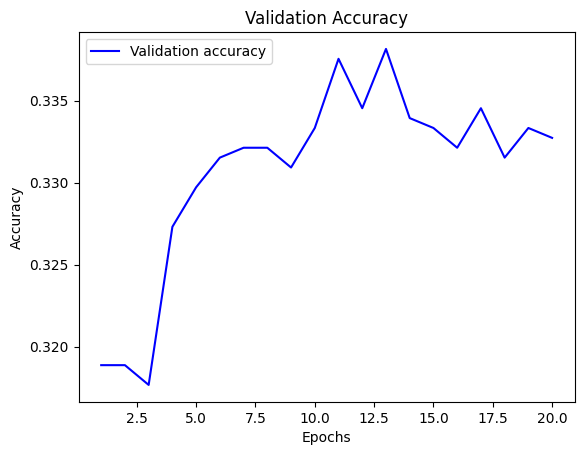

In [73]:
# train_loss = epochHistory['train']['loss']
# train_epoch = epochHistory['train']['epoch']
val_acc = epochHistory['val']['eval_accuracy']
val_epoch = epochHistory['val']['epoch']


# b is for "solid blue line"
plt.plot(val_epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

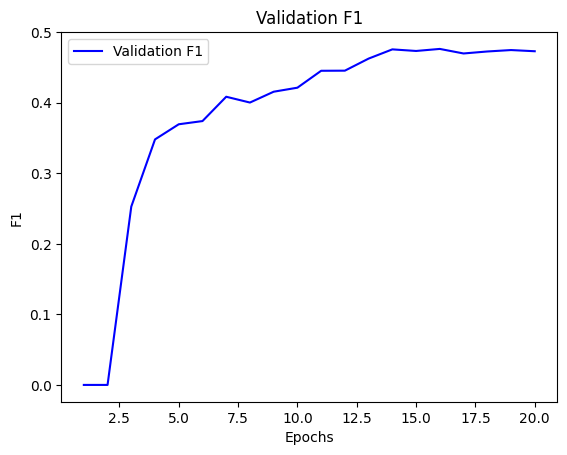

In [74]:
# train_loss = epochHistory['train']['loss']
# train_epoch = epochHistory['train']['epoch']
val_f1 = epochHistory['val']['eval_f1']
val_epoch = epochHistory['val']['epoch']



# b is for "solid blue line"
plt.plot(val_epoch, val_f1, 'b', label='Validation F1')
plt.title('Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()

plt.show()

In [ ]:
epochHistory['val'].keys()
import re

val_f1 = epochHistory['val']['eval_f1']
val_epoch = epochHistory['val']['epoch']
plt.plot(val_epoch, val_f1, 'b', linewidth=3, label='Overall Validation F1')

for key, value in epochHistory['val'].items():
  if not key.endswith('metrics'):
    continue
  title = re.findall(r'eval_(.*)_',key)[0]
  #get values into a single dict
  concatenated_dict = {}
  for dictionary in epochHistory['val'][key]:
      for key, value in dictionary.items():
          if key not in concatenated_dict:
              concatenated_dict[key] = []
          concatenated_dict[key].append(value)
  valCategories_f1 = concatenated_dict['f1']
  plt.plot(val_epoch, valCategories_f1, label=f'{title} F1')


plt.title('Validation F1 by Categories')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()

plt.show()

#### Multiple Model Investigation

In [51]:
# Optional, Reinitialize pathways shown above (copied and pasted, you must CHANGE if they do not match)
model_name = "HRAF_MultiLabel_SubClasses_Kfolds"
path = f"" #Path to centralized file locations
model_folder = "Model_4_WeightByLearning" #this is where the output folders will be created and where a centralized model is made.
model_path = f"{path}{model_folder}"



# Get list of models through common directory
files_dir = [
    f for f in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, f))
]

### OPTIONAL CHANGE
# Redo the text for the file names to better fit graphs (feel free to comment out)
def lowNum(text):
    startText =  'Learning_Rate_'
    regx = fr'{startText}([a-zA-Z0-9\.\-]+)'
    num = re.findall(regx,text)[0]
    return float(num)
files_dir.sort(reverse=True, key=lowNum)



epochHistory_dict = {}
for file in files_dir:

    history_path = f"{model_path}/{file}"
    f = open(history_path+"/HistoryLog.json")
    history_list = json.load(f)
    f.close()
    epochHistory= epochDictCreator(history_list)
    epochHistory_dict[file] = epochHistory
    


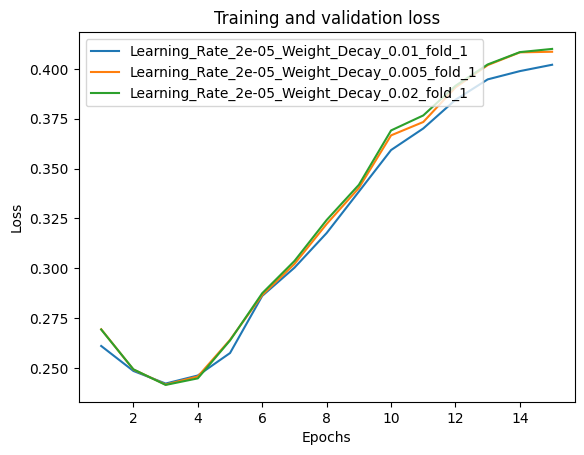

In [52]:
# Show Validation error rate
for key, epochHistory in epochHistory_dict.items():
    val_loss = epochHistory['val']['eval_loss']
    val_epoch = epochHistory['val']['epoch']
    plt.plot(val_epoch, val_loss, label=key)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

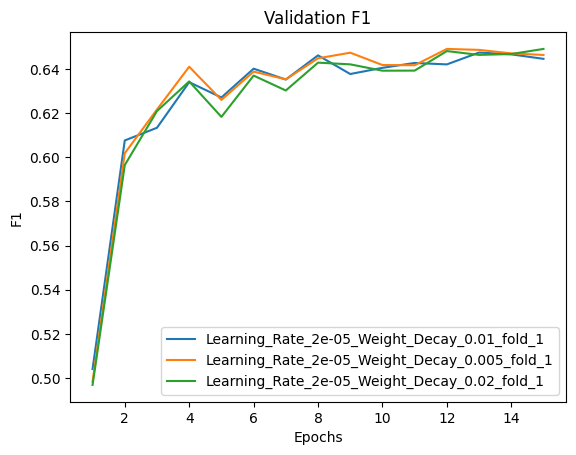

In [53]:
# Show F1 score improvements
for key, epochHistory in epochHistory_dict.items():
    val_f1 = epochHistory['val']['eval_f1']
    val_epoch = epochHistory['val']['epoch']
    plt.plot(val_epoch, val_f1, label=key)
plt.title('Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
plt.show()